In [1]:
from cvx.stat_arb.ccp import *
from backtest import run_finding_backtest
from utils import *
import seaborn as sns

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
prices_full = pd.read_csv("../data/stock_prices.csv", index_col=0, parse_dates=True)
market_cap = pd.read_csv("../data/market_cap.csv", index_col=0, parse_dates=True)
spreads = pd.read_csv("../data/spreads_stocks.csv", index_col=0, parse_dates=True)
spreads = spreads.rolling(5).mean().ffill().fillna(10 * (0.01**2)).abs()

In [3]:
results, portfolios = run_finding_backtest(
    prices_full,
    market_cap,
    P_max=100,
    moving_midpoint=True,
    midpoint_memory=21,
    T_max=125,
)

8% 16% 24% 32% 40% 48% 56% 64% 72% 80% 88% 96% 
Finished after looking for stat-arbs 127 times


Total number of (potential) SAs found: 1270
Average number of assets per SA: 5.3
Median number of assets per SA: 5.0
Total number of validated SAs: 711
max: 10
min: 1


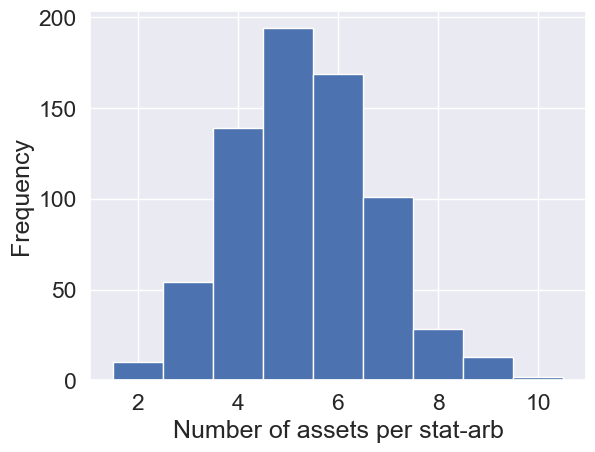

In [11]:
### How many assets per SA on average
lens = []
n_stat_arbs = 0

for res in results:
    stat_arb = res.stat_arb
    lens.append(stat_arb.stocks.shape[0])
    n_stat_arbs += 1

iterations = 127  # XXX number of iterations printed in previous cell
K = 10
print(f"Total number of (potential) SAs found: {iterations*K}")
print(f"Average number of assets per SA: {np.mean(lens):.1f}")
print(f"Median number of assets per SA: {np.median(lens):.1f}")
print(f"Total number of validated SAs: {n_stat_arbs}")
print(f"max: {np.max(lens)}")
print(f"min: {np.min(lens)}")
plt.hist(lens, bins=np.arange(1.5, 11.5, 1))
plt.xlabel("Number of assets per stat-arb")
plt.ylabel("Frequency");

# Analyze results

### Simulate stat-arb portfolios to compute metrics

In [5]:
all_traded_assets = []

for portfolio in portfolios:
    all_traded_assets += portfolio.units.columns.tolist()
all_traded_assets = list(set(all_traded_assets))

means = []
stdevs = []
sharpes = []
profits = []
min_navs = []
min_cum_profs = []
drawdowns = []

n_busts = 0

for i, portfolio in enumerate(portfolios):
    res = results[i]

    (
        mean,
        stdev,
        sharpe,
        mean_profit,
        min_nav,
        min_cum_prof,
        drawdown,
        went_bust,
    ) = simulate(res, portfolio, spreads[all_traded_assets], lev_fraction=0.5)

    means.append(mean)
    stdevs.append(stdev)
    sharpes.append(sharpe)
    profits.append(mean_profit)
    min_navs.append(min_nav)
    min_cum_profs.append(min_cum_prof)
    drawdowns.append(drawdown)

    n_busts += went_bust

stat_arb_metrics = pd.DataFrame(
    {
        "means": means,
        "stdevs": stdevs,
        "sharpes": sharpes,
        "profits": profits,
        "min_navs": min_navs,
        "min_cum_prof": min_cum_prof,
        "drawdowns": drawdowns,
    }
)

In [6]:
print(f"Number of busts: {n_busts}")

Number of busts: 0


In [7]:
avg_lens = np.mean(lens)
median_len = np.median(lens)
n_unique_stat_arbs = n_stat_arbs

means = stat_arb_metrics.means
stdevs = stat_arb_metrics.stdevs
sharpes = stat_arb_metrics.sharpes
profits = stat_arb_metrics.profits
min_navs = stat_arb_metrics.min_navs
min_cum_prof = stat_arb_metrics.min_cum_prof
drawdowns = stat_arb_metrics.drawdowns

print(f"Average number of assets per SA: {avg_lens:.1f}")
print(f"Median number of assets per SA: {median_len:.1f}")
print(f"Number of unique SAs: {n_unique_stat_arbs}")
print(f"Mean profit: {profits.mean():.2f}")
print(f"Median profit: {profits.median():.2f}")
print(f"Std profit: {profits.std():.2f}")
print(f"75th percentile: {profits.quantile(0.75):.2f}")
print(f"25th percentile: {profits.quantile(0.25):.2f}")
print(f"Fraction profitable: {(profits > 0).mean():.2f}")
print(f"Average minimum cumulative profit: {min_cum_prof.mean():.2f}")

print("\nMean return")
print(f"Mean return: {means.mean():.2f}")
print(f"Median return: {means.median():.2f}")
print(f"75th percentile return: {means.quantile(0.75):.2f}")
print(f"25th percentile return: {means.quantile(0.25):.2f}")
print(f"Fraction positive: {(means > 0).mean():.2f}")


print("\nRisk")
print(f"Mean risk: {stdevs.mean():.2f}")
print(f"Median risk: {stdevs.median():.2f}")
# print(f"Std risk: {stdevs.std():.2f}")
print(f"75th percentile risk: {stdevs.quantile(0.75):.2f}")
print(f"25th percentile risk: {stdevs.quantile(0.25):.2f}")

print("\nSharpe")
print(f"Average Sharpe: {sharpes.mean():.2f}")
print(f"Median Sharpe: {sharpes.median():.2f}")
# print(f"Std Sharpe: {sharpes.std():.2f}")
print(f"75th percentile Sharpe: {sharpes.quantile(0.75):.2f}")
print(f"25th percentile Sharpe: {sharpes.quantile(0.25):.2f}")
print(f"Fraction positive: {(sharpes > 0).mean():.2f}")

print("\nDrawdown")
print(f"Mean drawdown: {drawdowns.mean():.2f}")
print(f"Median drawdown: {drawdowns.median():.2f}")
# print(f"Std drawdown: {drawdowns.std():.2f}")
print(f"75th percentile drawdown: {drawdowns.quantile(0.75):.2f}")
print(f"25th percentile drawdown: {drawdowns.quantile(0.25):.2f}")

Average number of assets per SA: 5.3
Median number of assets per SA: 5.0
Number of unique SAs: 711
Mean profit: 1.58
Median profit: 1.18
Std profit: 3.03
75th percentile: 2.52
25th percentile: 0.14
Fraction profitable: 0.79
Average minimum cumulative profit: -0.37

Mean return
Mean return: 0.16
Median return: 0.12
75th percentile return: 0.24
25th percentile return: 0.03
Fraction positive: 0.81

Risk
Mean risk: 0.20
Median risk: 0.15
75th percentile risk: 0.25
25th percentile risk: 0.09

Sharpe
Average Sharpe: 0.84
Median Sharpe: 0.87
75th percentile Sharpe: 1.51
25th percentile Sharpe: 0.21
Fraction positive: 0.81

Drawdown
Mean drawdown: 0.12
Median drawdown: 0.09
75th percentile drawdown: 0.15
25th percentile drawdown: 0.05


### Number of active stat-arbs over time

Average number of active stat arbs: 37.08
Median number of active stat arbs: 40.00
Maximum number of active stat arbs: 53.00
Minimum number of active stat arbs: 3.00


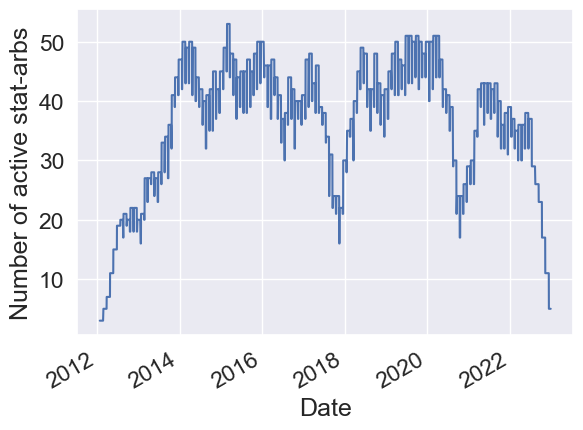

In [12]:
times = prices_full.index
n_active = pd.Series(index=times, data=0)

for res in results:
    entry_date = res.metrics.entry_date
    exit_date = res.metrics.exit_date

    n_active.loc[entry_date:exit_date] += 1
    n_active.loc[
        exit_date
    ] -= 1  # to account for the fact that the last day is not active

n_active = n_active[n_active > 0]

n_active.plot()
plt.ylabel("Number of active stat-arbs")
plt.xlabel("Date")

print(f"Average number of active stat arbs: {n_active.mean():.2f}")
print(f"Median number of active stat arbs: {n_active.median():.2f}")
print(f"Maximum number of active stat arbs: {n_active.max():.2f}")
print(f"Minimum number of active stat arbs: {n_active.min():.2f}")

### Example stat-arbs

In [13]:
quantile_low = 0.16
quantile_high = 0.715
quantiles = means.quantile([quantile_low, quantile_high])
quantiles

0.160   -0.027084
0.715    0.215592
Name: means, dtype: float64

LOCKHEED MARTIN CORP, Manufacturing
SERVICENOW INC, Professional, Scientific, and Technical Services
GILEAD SCIENCES INC, Manufacturing
N X P SEMICONDUCTORS N V, Manufacturing
stat-arb:  -0.4×21178+0.1×13447+1.7×77274+0.3×12084


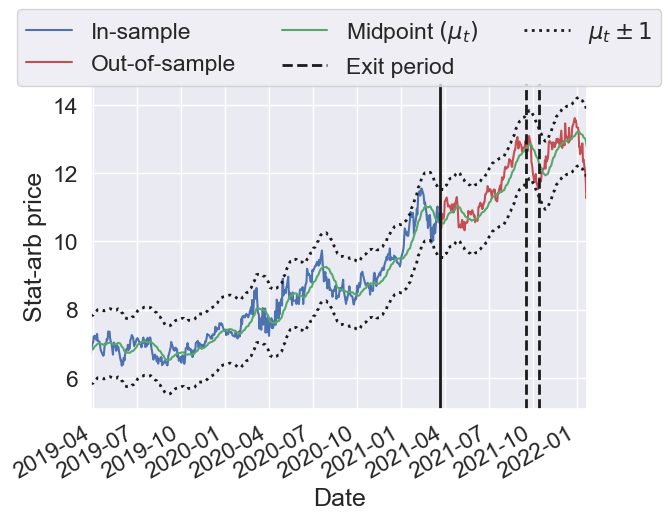

<Figure size 500x500 with 0 Axes>

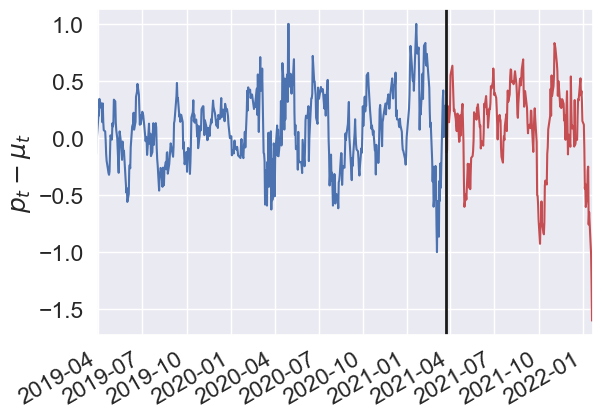

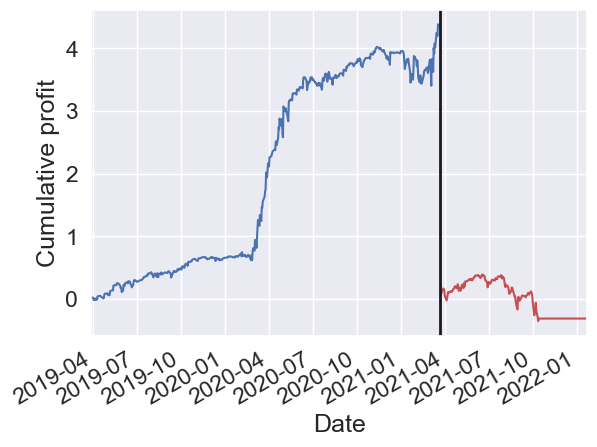

In [14]:
res_low = results[means[(means - quantiles[quantile_low]).abs().argsort()[:1]].index[0]]
plot_stat_arb(res_low, insample_bound=1, outsample_bound=np.inf, spreads=spreads);

MORGAN STANLEY DEAN WITTER & CO, Management of Companies and Enterprises
MONSANTO CO NEW, Manufacturing
WALGREEN CO, Retail Trade
ACCENTURE PLC IRELAND, Professional, Scientific, and Technical Services
ARCELORMITTAL S A LUXEMBOURG, Manufacturing
PIONEER NATURAL RESOURCES CO, Mining, Quarrying, and Oil and Gas Extraction
stat-arb:  -11.7×69032+3.4×88668-2.3×19502+6.1×89071+11.9×85261+2.6×75241


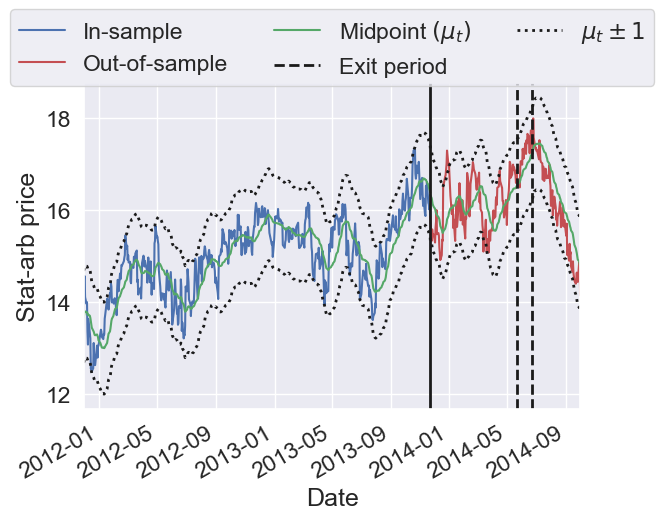

<Figure size 500x500 with 0 Axes>

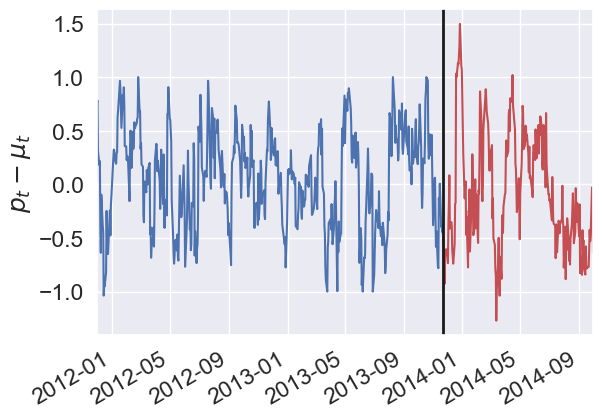

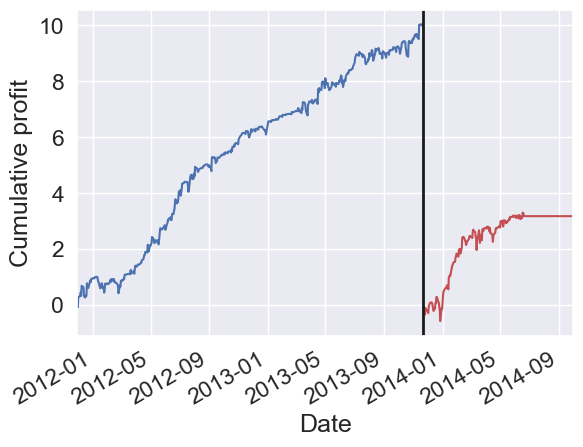

In [18]:
quantile_low = 0.16
quantile_high = 0.72
quantiles = means.quantile([quantile_low, quantile_high])
quantiles

res_high = results[
    means[(means - quantiles[quantile_high]).abs().argsort()[:1]].index[0]
]
plot_stat_arb(res_high, insample_bound=1, outsample_bound=np.inf, spreads=spreads);